**SOFT DEADLINE:** `20.03.2022 23:59 msk` 

# [5 points] Part 1. Data cleaning

The task is to clear the text data of the crawled web-pages from different sites. 

It is necessary to ensure that the distribution of the 100 most frequent words includes only meaningful words in english language (not particles, conjunctions, prepositions, numbers, tags, symbols).

Determine the order of operations below and carry out the appropriate cleaning.

1. Remove non-english words
1. Remove html-tags (try to do it with regular expression, or play with beautifulsoap library)
1. Apply lemmatization / stemming
1. Remove stop-words
1. Additional processing - At your own initiative, if this helps to obtain a better distribution

#### Hints

1. To do text processing you may use nltk and re libraries
1. and / or any other libraries on your choise

#### Data reading

The dataset for this part can be downloaded here: `https://drive.google.com/file/d/1wLwo83J-ikCCZY2RAoYx8NghaSaQ-lBA/view?usp=sharing`

In [1]:
import pandas as pd

In [2]:
from bs4 import BeautifulSoup
from typing import List, Set, Tuple
from collections import Counter

import re
import numpy as np

import nltk
from nltk.tokenize import TreebankWordTokenizer, WhitespaceTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     /Users/tiginamaria1999/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.2)

In [209]:
df = pd.read_csv('web_sites_data.csv')
df = df.rename(columns={'text': 'html'})
df = df.drop_duplicates()
df = df[:1000]
df

,html
0,"<html>\n<head profile=""http://www.w3.org/2005/..."
1,"<html>\n<head profile=""http://www.w3.org/2005/..."
2,"<html>\n<head profile=""http://www.w3.org/2005/..."
3,"<html>\n<head profile=""http://www.w3.org/2005/..."
4,"<html>\n<head profile=""http://www.w3.org/2005/..."
...,...
1464,<!DOCTYPE html>\n<html dir='ltr' id='document'...
1465,<!DOCTYPE html>\n<html dir='ltr' id='document'...
1466,<!DOCTYPE html>\n<html dir='ltr' id='document'...
1467,<!DOCTYPE html>\n<html dir='ltr' id='document'...


#### Data processing

In [211]:
def preprocess_text(text: str) -> str:
    text = re.sub(r"[^\w]", " ", text)
    text = re.sub(r"[\d]", " ", text)
    text = text.lower()
    
    tokenizer = TreebankWordTokenizer()
    tokens = tokenizer.tokenize(text)
        
    lemmatizer = WordNetLemmatizer()    
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    stemmer = PorterStemmer() 
    tokens = [stemmer.stem(token) for token in tokens]

    stop_words = set(stopwords.words("english"))
    words = set(nltk.corpus.words.words())
    tokens = [token for token in tokens if token in words and token not in stop_words]

    return ' '.join(tokens)

def html_to_text(html: str) -> str:
    soup = BeautifulSoup(html)
    text = soup.get_text()
    text = preprocess_text(text)
    
    return text

def split_to_tokens(text: str) -> List[str]:
    return text.split()

In [212]:
df['text'] = df['html'].apply(html_to_text)

In [213]:
df.to_csv('web_sites_data_prep.csv', index=False)

In [214]:
df = pd.read_csv('web_sites_data_prep.csv')

#### Vizualization

As a visualisation, it is necessary to construct a frequency distribution of words (the 100 most common words), sorted by frequency. 

For visualization purposes we advice you to use plotly, but you are free to choose other libraries

In [215]:
tokens = np.concatenate(df['text'].apply(split_to_tokens)).tolist()
common = Counter(tokens).most_common(100)
words, count = zip(*common)

<BarContainer object of 100 artists>

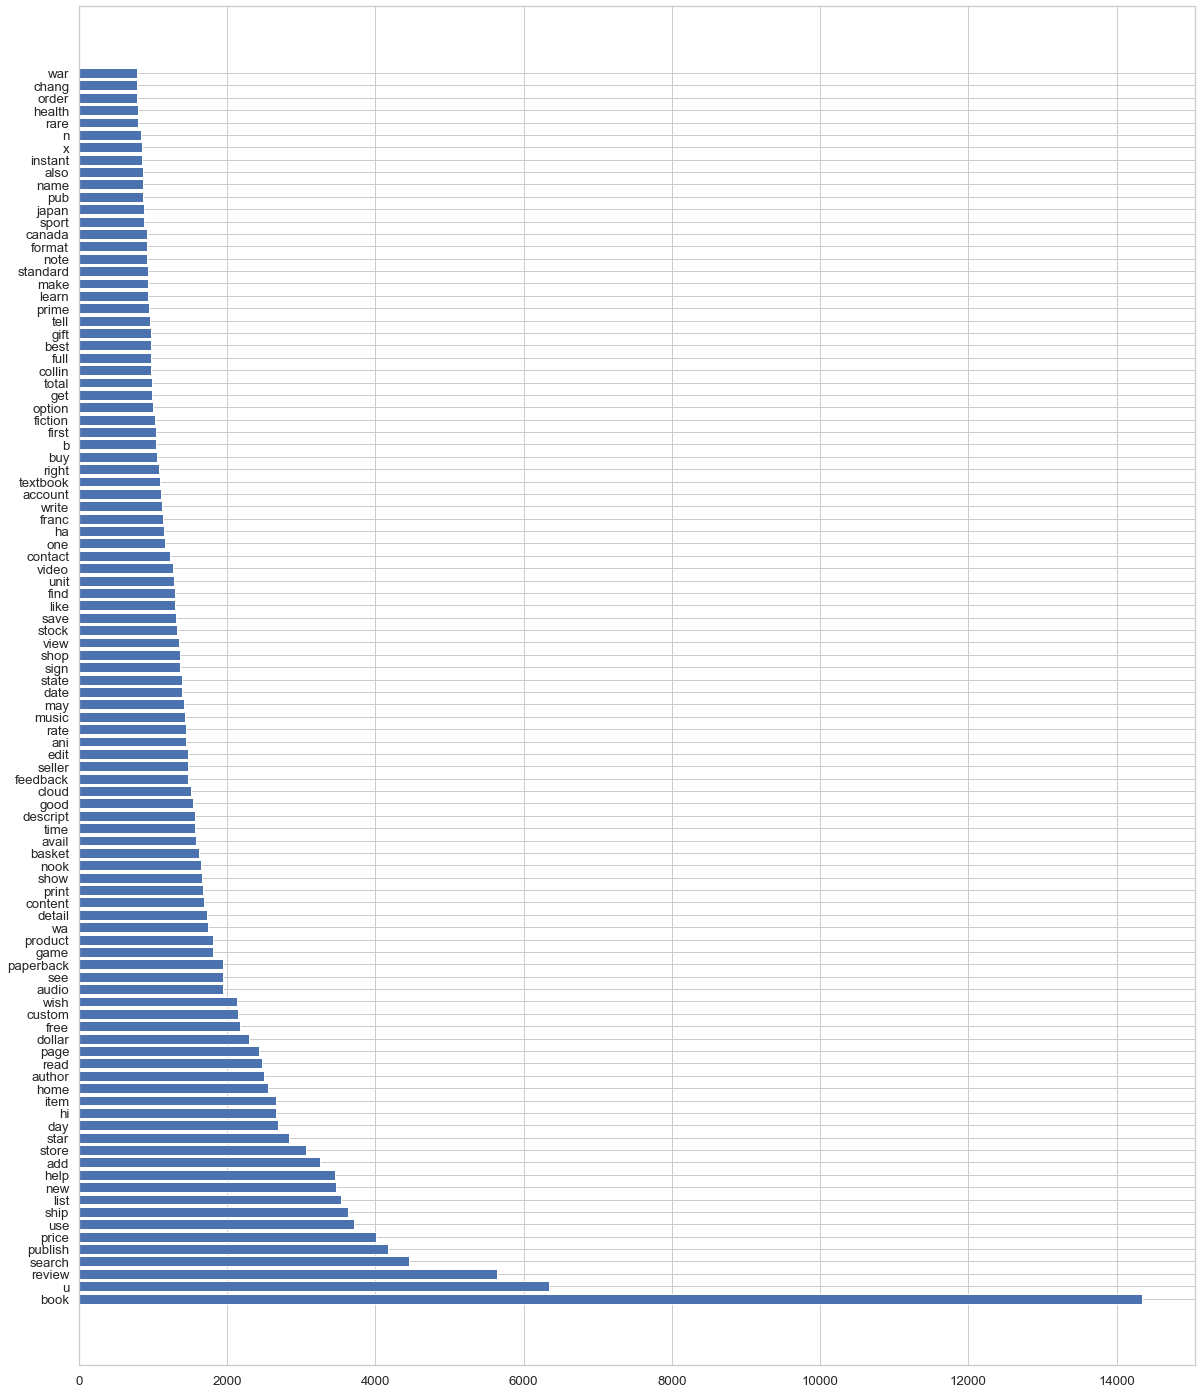

In [216]:
fig, ax = plt.subplots(figsize=(20,25))
ax.barh(words, count)

#### Provide examples of processed text (some parts)

Is everything all right with the result of cleaning these examples? What kind of information was lost?

In [217]:
df['text'][0]

'eric love war eric love war author eric love war avail suggest short walk shore last grain low gear recommend box bookmark show recommend topic memoir format war publish bind audio page date publish audio weight pound size x x inch edit price giver oh moocher ca deb descript book descript made summer pow eric among walk away prison camp wa german camp behind line went mountain help local retreat peasant shelter three month classic memoir selfless danger hi hope local girl later hi wife told punch interest hood freedom avail b add save later web site edit recommend'

# [10 points] Part 2. Duplicates detection. LSH

#### Libraries you can use

1. LSH - https://github.com/ekzhu/datasketch
1. LSH - https://github.com/mattilyra/LSH
1. Any other library on your choise

1. Detect duplicated text (duplicates do not imply a complete word-to-word match, but texts that may contain a paraphrase, rearrangement of words, sentences)
1. Make a plot dependency of duplicates on shingle size (with fixed minhash length) 
1. Make a plot dependency of duplicates on minhash length (with fixed shingle size)

In [218]:
from hashlib import sha1
import numpy as np
from datasketch.minhash import MinHash
from datasketch.weighted_minhash import WeightedMinHashGenerator
from datasketch.lsh import MinHashLSH

In [247]:
def get_shingles(text: str, num_shingles: int=4) -> Set[str]:
    return set([text[i:(i + num_shingles)] for i in range(0, len(text), num_shingles)])

def get_min_hash(shingles: List[str], num_perm: int=128) -> MinHash:
    m = MinHash(num_perm=num_perm)
    for d in set(shingles):
        m.update(d.encode('utf8'))
        
    return m

def get_min_hash_lsh(min_hashes: List[Tuple[int, MinHash]], num_perm: int=128, threshold: float=0.9) -> MinHashLSH:
    lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
    with lsh.insertion_session() as session:
        for i, min_hash in min_hashes:
            session.insert(str(i), min_hash)
            
    return lsh

def get_duplicates(lsh: MinHashLSH, min_hashes: List[Tuple[int, MinHash]]) -> List[int]: 
    duplicates = []
    for i, min_hash in min_hashes:
        d = lsh.query(min_hash)
        if len(d) > 1:
            duplicates.append(d)
    return duplicates

def get_duplicates_count(duplicates: List[List[int]]) -> int:
    return sum([1 if len(d) == 1 else 0 for d in duplicates])

In [248]:
df = df.drop_duplicates()

In [249]:
n_shingles = [2, 4, 6, 8, 10]
duplicates_count = []
duplicates_gsize = []

for n in n_shingles:
    shingles = df['text'].apply(get_shingles, num_shingles=n)
    
    min_hashes = shingles.apply(get_min_hash, num_perm=128)
    min_hashes = list(enumerate(min_hashes))
    
    lsh = get_min_hash_lsh(min_hashes, num_perm=128)
    duplicates = get_duplicates(lsh, min_hashes)
    duplicates_count.append(len(duplicates))
    duplicates_gsize.append(np.mean(np.array(list(map(len, duplicates)))))

Text(0, 0.5, 'Number of duplicates')

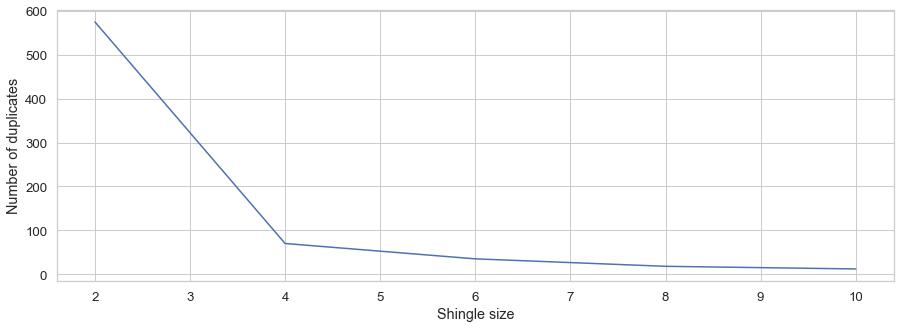

In [250]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(n_shingles, duplicates_count)
ax.set_xlabel('Shingle size')
ax.set_ylabel('Number of duplicates')

Text(0, 0.5, 'Mean number of duplicates in group')

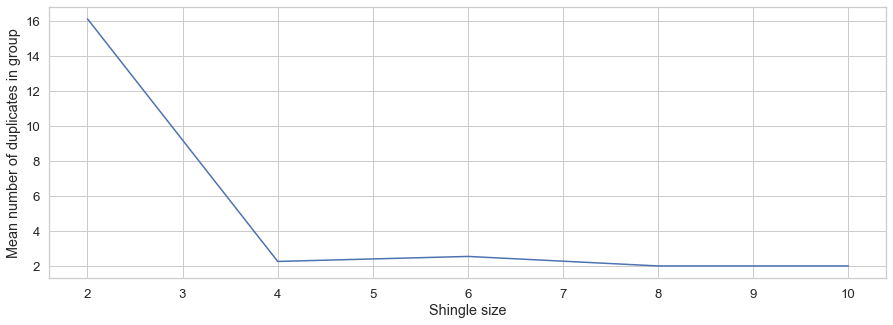

In [251]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(n_shingles, duplicates_gsize)
ax.set_xlabel('Shingle size')
ax.set_ylabel('Mean number of duplicates in group')

In [258]:
n_permutations = [8, 16, 32, 64, 128, 256, 512]
duplicates_count = []
duplicates_gsize = []

for n in n_permutations:
    shingles = df['text'].apply(get_shingles, num_shingles=4)
    
    min_hashes = shingles.apply(get_min_hash, num_perm=n)
    min_hashes = list(enumerate(min_hashes))
    
    lsh = get_min_hash_lsh(min_hashes, num_perm=n)
    
    duplicates = get_duplicates(lsh, min_hashes)
    duplicates_count.append(len(duplicates))
    duplicates_gsize.append(np.mean(np.array(list(map(len, duplicates)))))

Text(0, 0.5, 'Number of duplicates')

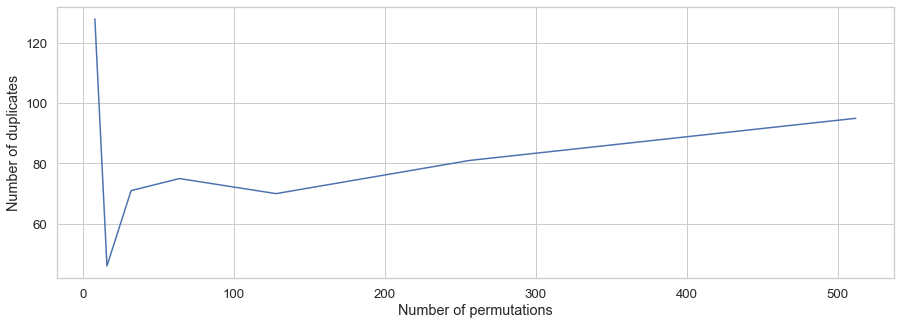

In [259]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(n_permutations, duplicates_count)
ax.set_xlabel('Number of permutations')
ax.set_ylabel('Number of duplicates')

Text(0, 0.5, 'Mean number of duplicates in group')

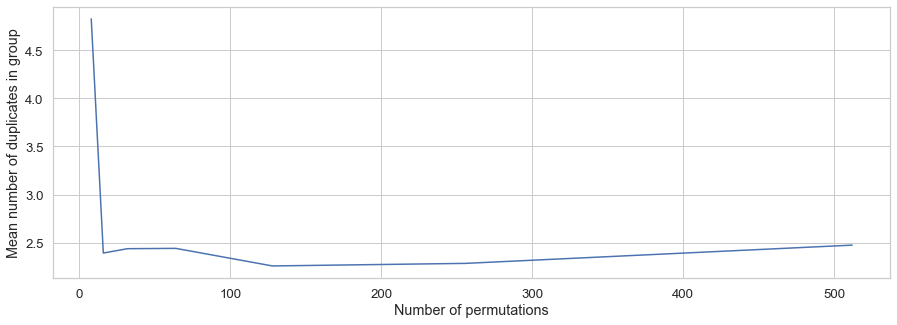

In [260]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(n_permutations, duplicates_gsize)
ax.set_xlabel('Number of permutations')
ax.set_ylabel('Mean number of duplicates in group')

# [Optional 10 points] Part 3. Topic model

In this part you will learn how to do topic modeling with common tools and assess the resulting quality of the models. 

In [79]:
df = pd.read_csv('data.csv')
df

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL
...,...,...,...
19574,id17718,"I could have fancied, while I looked at it, th...",EAP
19575,id08973,The lids clenched themselves together as if in...,EAP
19576,id05267,"Mais il faut agir that is to say, a Frenchman ...",EAP
19577,id17513,"For an item of news like this, it strikes us i...",EAP


The provided data contain chunked stories by Edgar Allan Poe (EAP), Mary Shelley (MWS), and HP Lovecraft (HPL).

The dataset can be downloaded here: `https://drive.google.com/file/d/14tAjAzHr6UmFVFV7ABTyNHBh-dWHAaLH/view?usp=sharing`

#### Preprocess dataset with the functions from the Part 1

In [80]:
df['text'] = df['text'].apply(preprocess_text)

In [154]:
df.to_csv('data_prep.csv', index=False)

In [187]:
df = pd.read_csv('data_prep.csv')

In [85]:
y_map = {'EAP': 0, 'MWS': 1, 'HPL': 2}

X = df['text']
y = df['author'].map(y_map).values

#### Quality estimation

Implement the following three quality fuctions: `coherence` (or `tf-idf coherence`), `normalized PMI`, `based on the distributed word representation`(you can use pretrained w2v vectors or some other model). You are free to use any libraries (for instance gensim) and components.

In [140]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

In [148]:
def tf_idf_coherence():
    pass

def nmpi_coherence(topics, texts):
    word2id = Dictionary(texts)
    cm = CoherenceModel(topics=topics, texts=texts, coherence='c_npmi', dictionary=word2id)
    return cm.get_coherence() 

def w2v_coherence():
    pass

### Topic modeling

Read and preprocess the dataset, divide it into train and test parts `sklearn.model_selection.train_test_split`. Test part will be used in classification part. For simplicity we do not perform cross-validation here, but you should remember about it.

Plot the histogram of resulting tokens counts in the processed datasets.

In [94]:
tokens = np.concatenate(df['text'].apply(split_to_tokens)).tolist()
common = Counter(tokens).most_common(100)
words, count = zip(*common)

<BarContainer object of 100 artists>

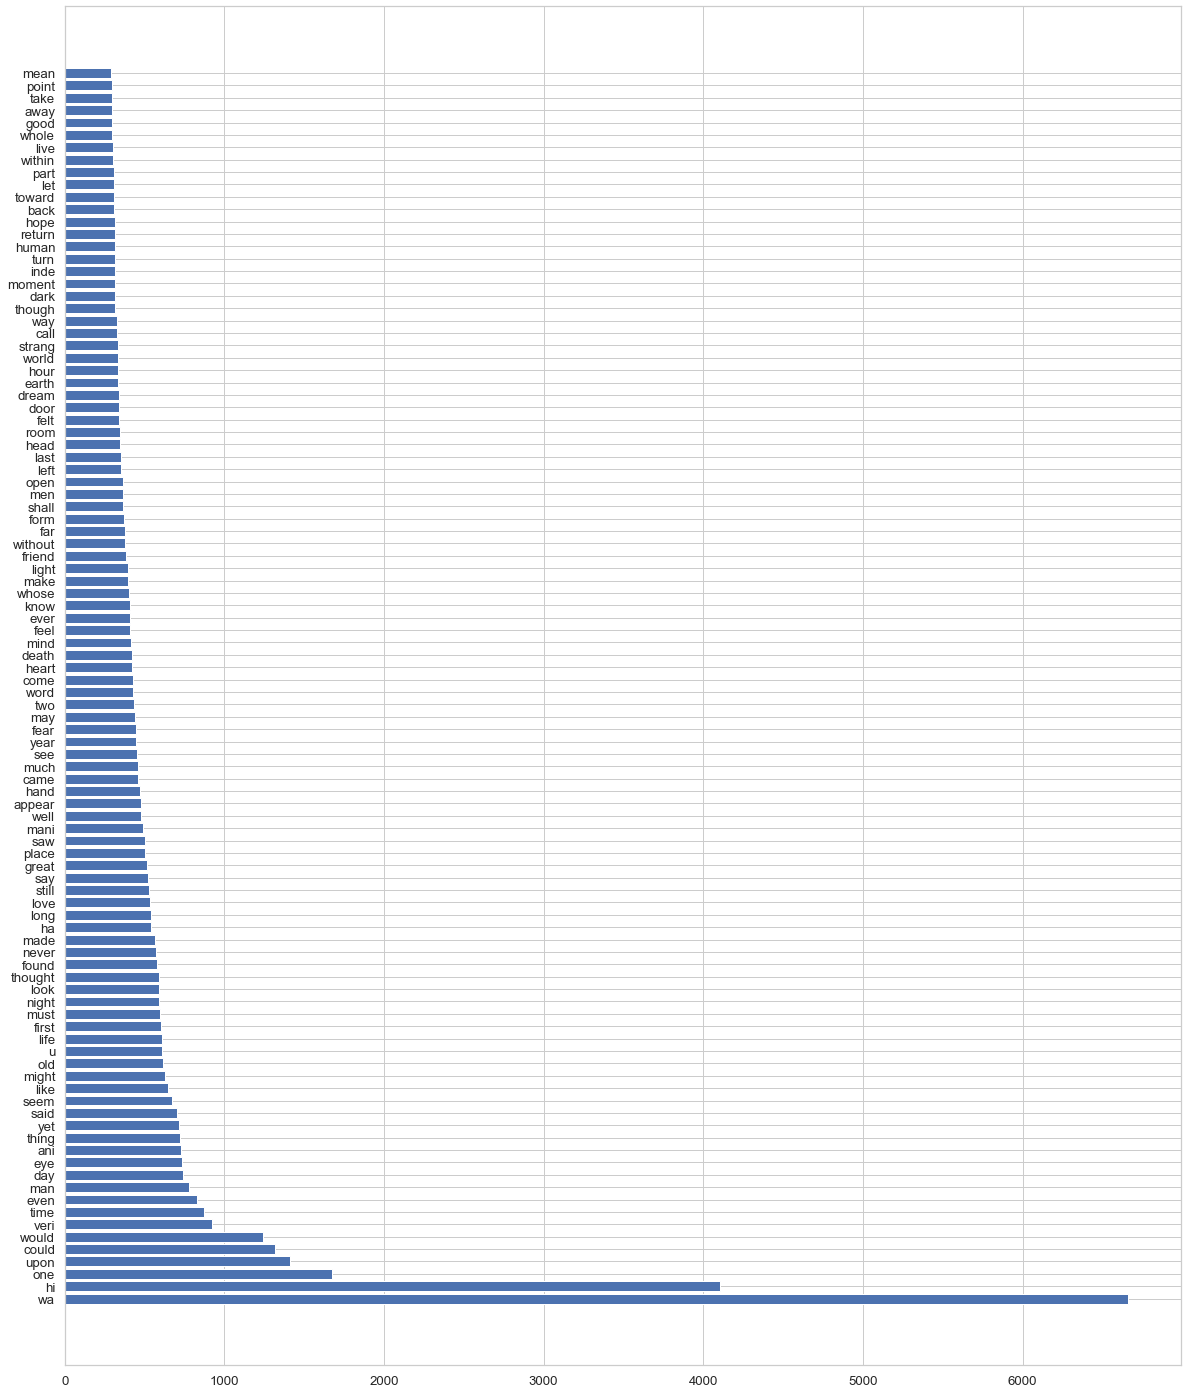

In [95]:
fig, ax = plt.subplots(figsize=(20,25))
ax.barh(words, count)

In [145]:
def get_top_words(topics: List[List[int]], feature_names: List[str], n_top_words: int) -> List[List[str]]:
    top_words = []
    for i, topic in enumerate(topics):
        top_words_ids = topic.argsort()[:-n_top_words - 1:-1]
        top_words_str = [feature_names[i] for i in top_words_ids]
        top_words.append(top_words_str)
    return top_words

def print_top_words(top_words: List[List[str]]):
    for i, tipic_top_words in enumerate(top_words):
        print(f'Topic #{i} : {tipic_top_words}\n')
        print("="*70)

#### NMF

Implement topic modeling with NMF (you can use `sklearn.decomposition.NMF`) and print out resulting topics. Try to change hyperparameters to better fit the dataset.

In [104]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF

In [117]:
vectorizer_tfidf = TfidfVectorizer()
tfidfs = vectorizer_tfidf.fit_transform(df['text'])
feature_names = vectorizer_tfidf.get_feature_names_out()

X_tf_idf = pd.DataFrame(tfidfs.toarray(), columns=feature_names)

In [119]:
nmf_model = NMF(n_components=10)

W = nmf_model.fit_transform(X_tf_idf)
H = nmf_model.components_

/Users/tiginamaria1999/opt/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [146]:
top_words = get_top_words(nmf_model.components_, feature_names, 10)
print_top_words(top_words)

Topic #0 : ['wa', 'first', 'sure', 'great', 'idea', 'much', 'far', 'door', 'born', 'air']

Topic #1 : ['hi', 'eye', 'hand', 'friend', 'father', 'express', 'mind', 'arm', 'head', 'face']

Topic #2 : ['would', 'ani', 'return', 'thought', 'make', 'might', 'hope', 'take', 'well', 'think']

Topic #3 : ['one', 'two', 'ha', 'ani', 'might', 'side', 'enter', 'old', 'singular', 'found']

Topic #4 : ['said', 'let', 'know', 'come', 'go', 'see', 'ye', 'word', 'shall', 'sir']

Topic #5 : ['veri', 'man', 'old', 'much', 'great', 'well', 'say', 'ha', 'inde', 'good']

Topic #6 : ['could', 'see', 'ani', 'word', 'make', 'help', 'distinguish', 'doubt', 'human', 'done']

Topic #7 : ['upon', 'look', 'hand', 'eye', 'found', 'fell', 'turn', 'subject', 'head', 'effect']

Topic #8 : ['thing', 'must', 'ani', 'say', 'know', 'knew', 'tell', 'speak', 'like', 'never']

Topic #9 : ['time', 'yet', 'even', 'day', 'love', 'night', 'still', 'life', 'never', 'first']



In [149]:
nmpi_coherence(top_words, df['tokens'])

0.0017602592809047163

#### LDA

Implement topic modeling with LDA (you can use gensim implementation) and print out resulting topics. Try to change hyperparameters to better fit the dataset.

In [122]:
df['tokens'] = df['text'].apply(split_to_tokens)
dct = Dictionary(df['tokens'])
corpus = [dct.doc2bow(text) for text in df['tokens']]

In [124]:
from gensim import models

lda_model = models.LdaModel(corpus, id2word=dct, num_topics=10)
corpus_lda = lda_model[corpus]

In [150]:
top_words = get_top_words(lda_model.get_topics(), list(dct.values()), 10)
print_top_words(top_words)

Topic #0 : ['wa', 'street', 'see', 'step', 'old', 'come', 'door', 'dream', 'sound', 'could']

Topic #1 : ['said', 'wa', 'de', 'may', 'say', 'think', 'shall', 'must', 'upon', 'better']

Topic #2 : ['wa', 'hi', 'one', 'word', 'night', 'day', 'father', 'u', 'like', 'would']

Topic #3 : ['wa', 'men', 'year', 'one', 'hi', 'part', 'wind', 'die', 'rush', 'near']

Topic #4 : ['hi', 'wa', 'time', 'would', 'upon', 'ani', 'could', 'veri', 'must', 'u']

Topic #5 : ['wa', 'thing', 'hi', 'world', 'call', 'well', 'man', 'ever', 'earth', 'mani']

Topic #6 : ['love', 'wa', 'one', 'heart', 'even', 'life', 'day', 'passion', 'may', 'new']

Topic #7 : ['hi', 'wa', 'eye', 'upon', 'mean', 'account', 'even', 'mind', 'feel', 'saw']

Topic #8 : ['wa', 'upon', 'could', 'one', 'eye', 'turn', 'might', 'window', 'head', 'half']

Topic #9 : ['wa', 'one', 'would', 'ha', 'veri', 'man', 'yet', 'hi', 'said', 'great']



In [151]:
nmpi_coherence(top_words, df['tokens'])

-0.012116124217500426

### Additive regularization of topic models 

Implement topic modeling with ARTM. You may use bigartm library (simple installation for linux: pip install bigartm) or TopicNet framework (`https://github.com/machine-intelligence-laboratory/TopicNet`)

Create artm topic model fit it to the data. Try to change hyperparameters (number of specific and background topics) to better fit the dataset. Play with smoothing and sparsing coefficients (use grid), try to add decorrelator. Print out resulting topics.

Write a function to convert new documents to topics probabilities vectors.

Calculate the quality scores for each model. Make a barplot to compare the quality.